< [Part 1: Scraping and Wrangling](spotify_1_scraping.ipynb) | [Main](index.ipynb) | [Part 3: Audio Features](spotify_3_audio_features.ipynb) >

---

# Basic Feature Exploration

Now that we've scraped our datasets (see [Part 1: Scraping and Wrangling](spotify_1_scraping.ipynb)), let's start exploring and visualizing the available features. Our primary goal is to find predictive signals in the features that distinguish the two datasets, but we'll also find a few interesting patterns along the way.

## Color Scheme

In plots below and in the notebooks that follow, I use a consistent color scheme to represent the two datasets. Since I have a fondness for pure, primary, colors, and red-green colorblind friendliness, I'm using a bold red and blue color scheme:

**My library = blue, Billboard Top = red.**

The red used is pure, primary red. Since primary blue is much darker than primary red (in relative luminance), I added enough green to give an azure with the same relative luminance (linearized) as primary red. This blue is still fully saturated, and perfectly orthogonal to red (i.e. there is no red in the azure). The actual perceived luminance will vary from display to display, but I did attempt to linearize my color calculation using typical display specs. I also made a purple that is the (again linearized) average of this red and blue, for later plots.

In [1]:
import string
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import datetime as dt
from wordcloud import WordCloud

%matplotlib inline

#Custom seaborn/matplotlib settings
rc = {'axes.edgecolor': '0', 'axes.labelcolor': '0', 'grid.color': '0', 
      'figure.figsize': [6, 6], 'lines.linewidth': '2', 'text.color': '0', 
      'xtick.color': '0', 'ytick.color': '0' }
sns.set(context='notebook', style='white', font_scale=1.5, rc=rc)

pd.options.display.max_columns = 50

red = (1,0,0)
blue = (0,.475,1) #Same relative luminance (linearized) as primary red (approx)
purple = (.736,.343,.736) #Linearized average between above red and blue

df = pd.read_hdf('./data/df.h5', 'main')

# Artists

First, let's have a look at the artists in each dataset. We will construct a simple bar plot showing the top 10 artists in each dataset, and the number of tracks by that artist.



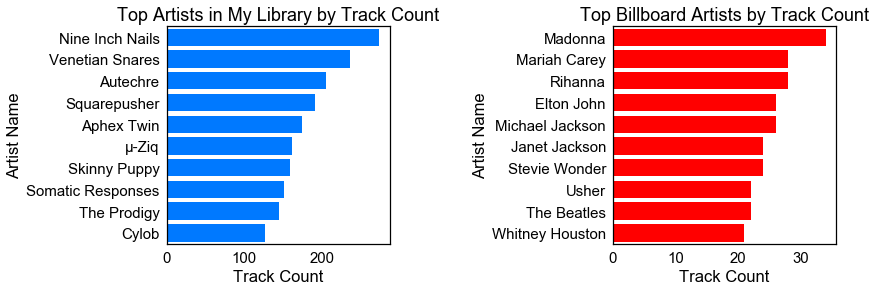

In [2]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,4))

df_temp = df[df.ds=='nix'].name_artist.value_counts().head(10).to_frame(
    name='count').reset_index()
p = sns.barplot(x='count',y='index',data=df_temp, color=blue, ax=ax1, 
                saturation=1)
ax1.set_ylabel('Artist Name') 
ax1.set_xlabel('Track Count')
ax1.set_title('Top Artists in My Library by Track Count');

df_temp = df[df.ds=='top'].name_artist.value_counts().head(10).to_frame(
    name='count').reset_index()
p = sns.barplot(x='count',y='index',data=df_temp, color=red, ax=ax2,
               saturation=1)
ax2.set_ylabel('Artist Name') 
ax2.set_xlabel('Track Count')
ax2.set_title('Top Billboard Artists by Track Count');

plt.subplots_adjust(wspace=1.0)

We can see that there is no overlap between the top artists.

We could also visualize top artists by the number of distinct *albums* represented in the datasets. Let's look at the entire dataset:

In [3]:
df_temp = df.groupby('name_artist').name_album.nunique().sort_values(
    ascending=False).head(10).to_frame(name='count').reset_index()
df_temp

,name_artist,count
0,Venetian Snares,33
1,Autechre,32
2,Squarepusher,27
3,Nine Inch Nails,24
4,Aphex Twin,21
5,Somatic Responses,17
6,Mariah Carey,16
7,Cylob,15
8,Rihanna,14
9,Drake,13


Since my library has more tracks by fewer artists, and the Billboard Top library contains more artists with less tracks each, we mostly see artists from my library here. This phenomenon is common when the two datasets are considered as a whole.  

---

These counts include albums from which only a single track appears in our datasets. Let's instead see the most popular artists, by number of albums *with at least 3 tracks* present in our datasets.

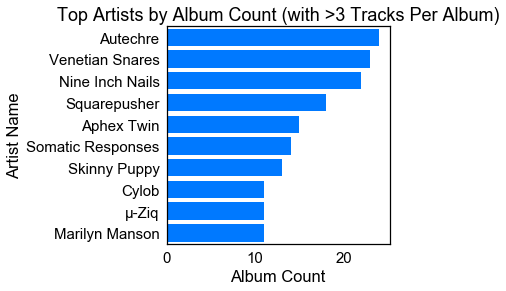

In [3]:
#Remove albums with less than 4 tracks.:
df_temp = df.groupby('name_album').filter(
    lambda x: x['name_album'].count()>3)

df_temp = df_temp.groupby('name_artist').name_album.nunique().sort_values(
    ascending=False).head(10).to_frame(name='count').reset_index()

plt.figure(figsize=(4,4))
p = sns.barplot(x='count',y='name_artist',data=df_temp, color=blue,
               saturation=1)
p.set_ylabel('Artist Name') 
p.set_xlabel('Album Count')
p.set_title('Top Artists by Album Count (with >3 Tracks Per Album)');

This doesn't change the result much, aside from focusing purely on my library.

# Song Titles

Now let's have a look at song titles. Specifically, let's see what are the most common song titles in the Billboard Top dataset. We'll strip out the title's punctuation and capitalization, and count the occurrence of each song title. We'll then show these counts along with a representative song title (a particular use of punctuation and capitalization).

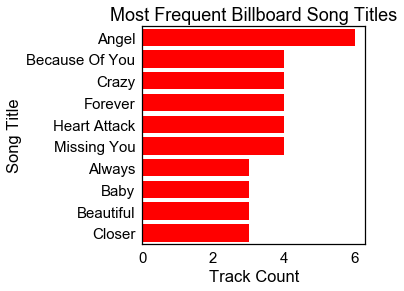

In [2]:
#Remove punctuation from a string
def nopunc(s):
    trans = str.maketrans('', '', string.punctuation)
    return s.translate(trans)

#Use most common title as a "representative" title.
def title_repr(titles):
    return titles.mode()[0]

#Group by lowercased/depunctuated names to make grouping case and punctuation
#insensitive. Aggregation returns title count and a representative title.
#Sort by count and return top 30 for plotting.
df_temp = df[df.ds=='top'].name.groupby( nopunc(df.name.str).str.lower() ).agg(
    [ 'count', title_repr ] ).reset_index()
df_temp = df_temp.sort_values(by=['count','title_repr'], 
                                  ascending=[False,True])

plt.figure(figsize=(4,4))
p = sns.barplot( x='count',y='title_repr',data=df_temp.head(10), color=red,
               saturation=1)
p.set_ylabel('Song Title') 
p.set_xlabel('Track Count')
p.set_title('Most Frequent Billboard Song Titles');

We can do little better than this. Let's make something like a very simplified word cloud of these titles. Since word clouds can be messy or misleading, we'll just display the titles in order of count, and scaled by count.

We'll build up an HTML string in a loop and render it using Jupyter's `display` function.

*Note: This may not render properly on some platforms, e.g. GitHub.*

In [3]:
#Extract the title strings as 1 list of titles per count.
string_lists = df_temp.groupby('count').apply(lambda x: list(x.title_repr))
string_lists = string_lists[::-1][:3] #Reverse order and only take top 3.

#Save counts for scaling.
counts = string_lists.index.values

html = """<div style="width: 630px; margin: 4px; \
overflow: auto; padding: 4px; text-align: center">
<div style="font-size:24px; line-height:24px">\
Most Popular Billboard Song Titles</div></div>
<div style="width: 630px; margin: 0px; \
overflow: auto; border: 1px solid black; \
padding: 10px; text-align: justify; text-align-last: center;">
"""

for count in counts:
    string_list = string_lists[count]
    titles = '.  '.join(string_list)
    fontsize = count*8
    padding = count*4
    
    for title in string_list:
        div_pre = """<div class="SongTitlesEntry" style="display: inline-block;\
font-family: Georgia,Cambria,Times,serif; padding: {}px; padding-left: {}px;\
padding-right: {}px; font-size:{}px; line-height:{}px">""".format(
            13, padding, padding, fontsize, fontsize)
        div_post = '</div>\n'
        html += div_pre + '⁃' + title + '⁃' + div_post
    html += '<br />\n'    
    
html += '</div>'
display( HTML(html) )

Poetic.

---

Just for the heck of it, let's also generate a word cloud for these titles (despite my love/hate relationship with word clouds). We'll plot the words in red, scaled by frequency. We'll also fade the titles by frequency to further highlight the more frequent titles, and to reduce clutter. All of the words will be horizontally aligned.

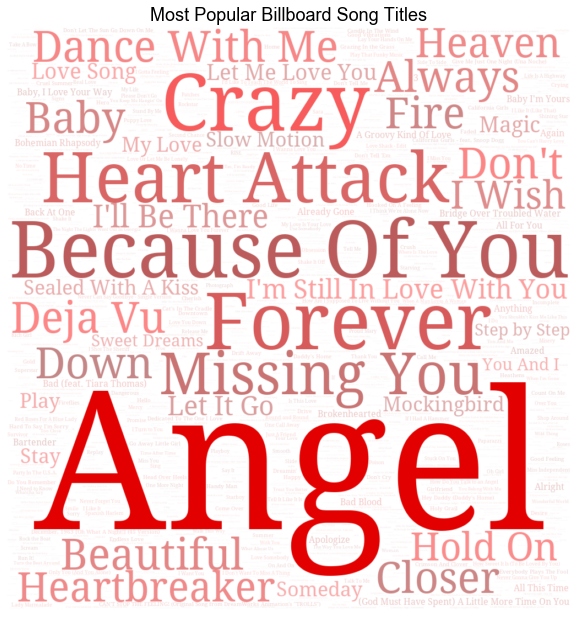

In [27]:
#Create a function that returns a color function for the word cloud that
#depends on font size
def make_color_func(background_color, max_font_size, color_list):
    
    #Turn color list into a matplotlib color map
    cmap = mpl.colors.LinearSegmentedColormap.from_list('mymap', color_list, 
                                                        N=256, gamma=1.0)
    
    #Color function to return
    def color_func(word, font_size, position, orientation, random_state=None,
                  **kwargs):
        #Select a random color from the color map
        base_color = cmap( np.random.rand() )[:3]
        #Use the current word's font size to determine the word's opacity
        opacity = np.sqrt( font_size/max_font_size )
        #Mix base_color with background_color according to calculated opacity
        color = tuple( int(255*( opacity*x+(1-opacity)*y ) ) 
                      for x,y in zip(base_color, background_color) )
        return color
    
    return color_func

background_color= (1,1,1)
max_font_size=340
color_list=[(1,0,0),(.5,0,0)] #Red color scheme

#Create color function and generate word cloud
lc_color_func = make_color_func(background_color=background_color, 
                                max_font_size=max_font_size,
                                color_list=color_list )
wc = WordCloud(font_path='./fonts/DroidSerif-Regular.ttf', max_words=10000, 
               width=1024, height=1024, relative_scaling=1, 
               background_color=tuple(int(255*x) for x in background_color),
               prefer_horizontal=1, min_font_size=1, color_func=lc_color_func,
               mode='RGBA', max_font_size=max_font_size)

#Pass words and counts into word cloud
wordscores = dict( zip(df_temp.title_repr, df_temp['count']) )
cloud = wc.generate_from_frequencies( wordscores )

#Create figure and display word cloud
plt.figure(figsize=[9,9])
p = plt.imshow(cloud, interpolation='bilinear', aspect='auto')
plt.tight_layout()
plt.axis('off')
p.axes.get_xaxis().set_visible(False)
p.axes.get_yaxis().set_visible(False)
plt.title('Most Popular Billboard Song Titles')

plt.show()

# Record Labels

Let's see the top record labels in each dataset (by  track count).

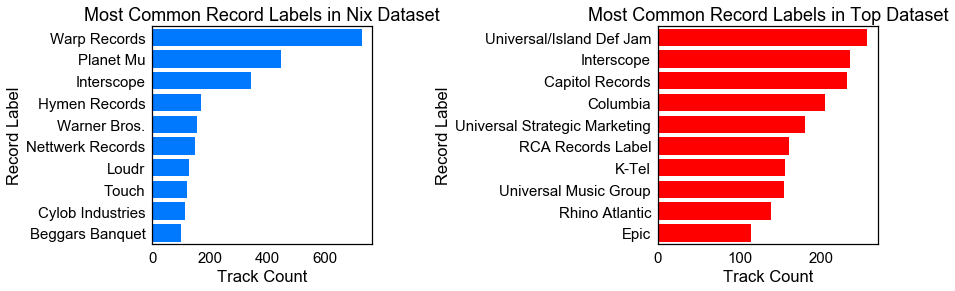

In [5]:
df_temp_nix = df[df.ds=='nix'].groupby('label')['id'].count().sort_values(
    ascending=False).head(10).to_frame().reset_index()
df_temp_top = df[df.ds=='top'].groupby('label')['id'].count().sort_values(
    ascending=False).head(10).to_frame().reset_index()

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(13,4))

sns.barplot(x='id',y='label',data=df_temp_nix, color=blue, ax=ax1, saturation=1)
ax1.set_ylabel('Record Label') 
ax1.set_xlabel('Track Count')
ax1.set_title('Most Common Record Labels in Nix Dataset');

sns.barplot(x='id',y='label',data=df_temp_top, color=red, ax=ax2, saturation=1)
ax2.set_ylabel('Record Label') 
ax2.set_xlabel('Track Count')
ax2.set_title('Most Common Record Labels in Top Dataset');

plt.subplots_adjust(wspace=1.3)

Aside from Interscope, we see very little overlap between the two datasets. My dataset is dominated by Warp Records, Planet Mu, and Interscope. 

To further investigate this, let's focus on my dataset and see the *artist* counts per label. We'll also inspect the per-label lists of artists.

In [8]:
#Make a column of lists of artists, sorted by name
df_temp = df[df.ds=='nix'].sort_values(by='name_artist').groupby(
    'label')['name_artist'].unique().to_frame().reset_index()

#Make column of artist counts from these lists
df_temp['numartists']=df_temp['name_artist'].transform( lambda x: len(x) )

#Using .style with no parameters to display full artist lists.
df_temp.sort_values('numartists',ascending=False).head(5).style

,label,name_artist,numartists
147,Loudr,['Aaron Cherof' 'Baiyon' 'Ben Prunty' 'Big Giant Circles' 'Bignic' 'Brent Kennedy' 'C418' 'Chipocrite' 'Daniel Olsén' 'Datassette' 'Decktonic' 'Disasterpeace' 'Eirik Suhrke' 'Gabe Terracciano' 'Hyperduck Soundworks' 'James Primate' 'Jay Tholen' 'Jim Guthrie' 'Josh Whelchel' 'Joshua Morse' 'Morusque' 'My Boy Elroy' 'Sanjjib' 'Scattle' 'Solar Fields' 'Souleye' 'Stemage' 'Steve McCullough' 'Surasshu' 'Tettix' 'Whitaker Trebella' 'coda' 'monomer' 'scntfc'],34
272,Warp Records,['AFX' 'Aphex Twin' 'Autechre' 'B12' 'Balil' 'Beaumont Hannant' 'Boards of Canada' 'Clark' 'Darrel Fitton' 'Dr Alex Paterson' 'Higher Intelligence Agency' 'I.A.O.' 'Jimmy Edgar' 'Kenny Larkin' 'Link' 'Lorenzo Senni' 'Mark Franklin' 'Milanese' 'Musicology' 'Oneohtrix Point Never' 'Plaid' 'Polygon Window' 'Richard Devine' 'Richard H. Kirk' 'Rustie' 'Scanner' 'Seefeel' 'Shobaleader One' 'Speedy J' 'Squarepusher' 'The Dice Man' 'Tim Exile' 'Up'],33
232,Stones Throw Records,"['Antonym' 'Aural Indifference' 'Bene Gesserit' 'Class Info' 'Crash Course In Science' 'Das Ding' 'Das Kabinette' 'Deux' 'Ende Shneafliet' 'Esplendor Geométrico' 'Felix Kubin' 'Geneva Jacuzzi' 'Hard Corps' 'In Aeternam Vale' 'In Trance 95' 'Linear Movement' 'Martin Dupont' 'Ohama' 'Oppenheimer Analysis' 'Philippe Laurent' 'Ruins' 'Somnambulist' 'Subject' 'Tempus Fugit' 'Turquoise Days' ""Who's Really Listening""]",26
258,Ubiktune,['Bacter' 'Bomb Boy' 'Chimeratio' 'Extent Of The Jam' 'Keishi Yonao' 'Linde' 'Naruto' 'Ryu Takami' 'Shnabubula' 'Simon Stålenhag' 'Zinger' 'ahlnold' 'cTrix' 'stinkbug' 'tenfour' 'zabutom'],16
188,Planet Mu,"['Bit_Meddler' 'Ceephax Acid Crew' ""Datach'i"" 'Doormouse' 'Hrvatski' 'Jega' 'Kid Spatula' 'Mike & Rich' 'Milanese' 'Nautilis' 'Speedranch vs End' 'Venetian Snares' 'Venetian Snares + Speedranch' '\\xB5-Ziq' 'exile*' 'µ-Ziq']",16


Interesting! This seems to be partially dominated by labels that put out compilations. Loudr, Stones Throw Records, and Ubiktune are all labels with compilations in my library. This artificially inflates the number of artists that are associated with that label and also present in my library.

Let's try again, but filter out artists with less than, say, 4 tracks in the dataset. We'll show the artists lists as well as a bar plot.

,label,name_artist,numartists
192,Warp Records,['AFX' 'Aphex Twin' 'Autechre' 'Boards of Canada' 'Lorenzo Senni' 'Milanese' 'Polygon Window' 'Richard Devine' 'Rustie' 'Shobaleader One' 'Squarepusher'],11
96,Interscope,['Danny Elfman' 'Dr. Dre' 'Hole' 'La Roux' 'Marilyn Manson' 'Nine Inch Nails' 'Nirvana' 'Nitzer Ebb' 'Portishead' 'Rob Zombie' 'Weezer'],11
136,Planet Mu,"['µ-Ziq' 'Ceephax Acid Crew' ""Datach'i"" 'exile*' 'Jega' 'Mike & Rich' 'Milanese' 'Venetian Snares' 'Venetian Snares + Speedranch' '\\xB5-Ziq']",10
185,Universal Music Group,['16BIT' 'Frank Zappa' 'Nirvana' 'Scott Walker' 'Skinny Puppy' 'Slayer' 'Tears For Fears'],7
167,Strategic Marketing,['Angelo Badalamenti' 'Barry Adamson' 'David Bowie' 'Marilyn Manson' 'Nine Inch Nails' 'Wall Of Voodoo'],6
113,Metropolis Records,['Funker Vogt' 'Grendel' 'KMFDM' 'OHGr' 'Psyclon Nine' ':Wumpscut:'],6
86,Hymen Records,"['Asche, Converter, Morgenstern' 'Converter' 'Imminent Starvation' 'Somatic Responses' 'Venetian Snares' 'Xanopticon']",6
150,Rhino/Warner Bros.,['Carl Stalling' 'Depeche Mode' 'Ministry' 'Prince'],4
190,Warner Bros.,"[""The B-52's"" 'Danny Elfman' 'Depeche Mode' 'DEVO']",4
118,Mute,['Fad Gadget' 'Nitzer Ebb' 'Throbbing Gristle'],3


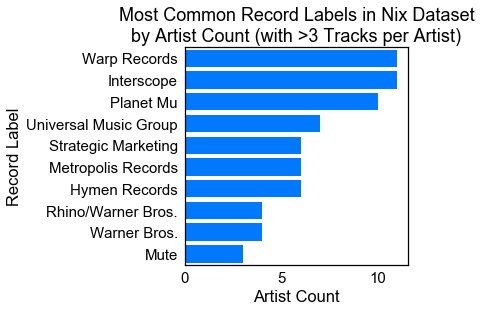

In [6]:
#Filter out artists with less than 4 tracks
df_temp = df[df.ds=='nix'].groupby('name_artist').filter(
    lambda x: x['id'].count()>3)

#Construct artist lists and counts.
df_temp = df_temp[df_temp.ds=='nix'].groupby('label')['name_artist'].unique(
            ).to_frame().reset_index()
df_temp['numartists']=df_temp['name_artist'].transform( lambda x: len(x) )

#Only top 10
df_temp = df_temp.sort_values('numartists',ascending=False).head(10)

plt.figure(figsize=(4,4))
p = sns.barplot(x='numartists',y='label',data=df_temp, color=blue, 
                saturation=1)
p.set_ylabel('Record Label') 
p.set_xlabel('Artist Count')
title = """\
Most Common Record Labels in Nix Dataset
by Artist Count (with >3 Tracks per Artist)\
"""
p.set_title(title);

#Using .style with no parameters to display full artist lists.
df_temp.style

This looks more reasonable, and matches up to some degree with the plot of labels by track count. 

Of the top three labels, two (Warp and Planet Mu) primarily release experimental electronic dance music, which is prevalent in my library. Interscope has a large presence due to the variety and sheer number of artists releasing under that label. In my dataset alone, Interscope represents genres such as rap, grunge, industrial, pop, classical, etc.

# Release Dates and Billboard Ranking Decade

Now, let's dive into dates! 

## Release Month and Day

First, let's generate bar plots for the number of tracks per month and day. 

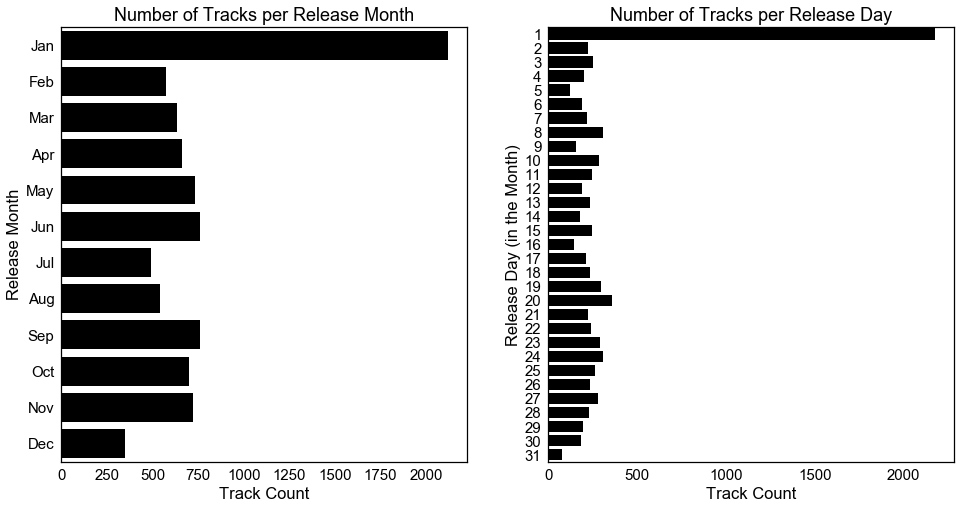

In [10]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,8))

p = sns.countplot(y='release_month', data=df, ax=ax1, color='black')

#Set month labels
months = ['Jan','Feb','Mar','Apr','May','Jun',
          'Jul','Aug','Sep','Oct','Nov','Dec']
p.set_yticklabels(months)

p.set_ylabel('Release Month')
p.set_xlabel('Track Count')
p.set_title('Number of Tracks per Release Month')

p = sns.countplot(y='release_day', data=df, ax=ax2, color='black')

#Convert day labels to integers.
ylabels = [ item.get_text() for item in p.get_yticklabels() ]
ylabels = [ str( int( float( label ) ) ) for label in ylabels ]
p.set_yticklabels(ylabels)

p.set_ylabel('Release Day (in the Month)')
p.set_xlabel('Track Count')
p.set_title('Number of Tracks per Release Day')

plt.subplots_adjust(wspace=.2)

We can see a suspicious peak at January and the 1st of the month. This is likely due to missing dates being falsely recorded as "January 1" during data entry.

## Release Day of the Week

Let's see if there is any relationship between day of the week and number of releases. We'll convert the date to a day of the week, and draw a simple bar plot.

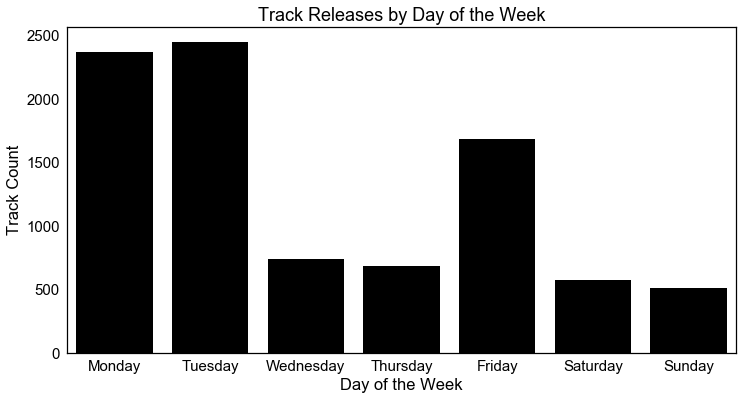

In [11]:
#Converts dates to day of the week
def date_to_weekday(date):
    year = int( date[0] )
    month = int( date[1] )
    day = int( date[2] )
    return dt.date(year,month,day).weekday()

plt.figure(figsize=(12,6))

cols = ['release_year','release_month','release_day']

#Convert to weekdays
s = df[cols].dropna().apply(date_to_weekday, axis=1)

#Convert numerical weekdays to strings for plotting purposes.
mapping = {0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',
           5:'Saturday',6:'Sunday'}
s = s.map(mapping)

order = ['Monday','Tuesday','Wednesday','Thursday',
         'Friday','Saturday','Sunday']
p = sns.countplot(s, color='k',order=order)

p.set_ylabel('Track Count')
p.set_xlabel('Day of the Week')
p.set_title('Track Releases by Day of the Week');

Interesting! There seems to be significantly more releases on Monday, Tuesday, and Friday. In order to understand this, I split the datasets in various ways, leading to an interesting observation: These 3 peaks can be somewhat isolated by splitting the data by the year of release or the country of origin. 

I followed this up with a bit of research, and discovered that prior to 2015, US labels typically released albums on Tuesdays, while most other non-US labels released on Mondays. After 2015, both switched to releasing on Fridays. (See e.g.: [Why Are Albums Released on Tuesday (For Now) in the U.S.?](https://www.billboard.com/articles/news/6487452/album-release-day-why-tuesday) and [Music Industry Sets Friday as New Global Release Day](https://www.rollingstone.com/music/news/music-industry-sets-friday-as-new-global-release-day-20150226) )

Let's examine these using a Seaborn `FacetGrid`. We'll construct a list of the most popular labels representing US and non-US labels, and split by that as well as the 2015 date of demarcation.

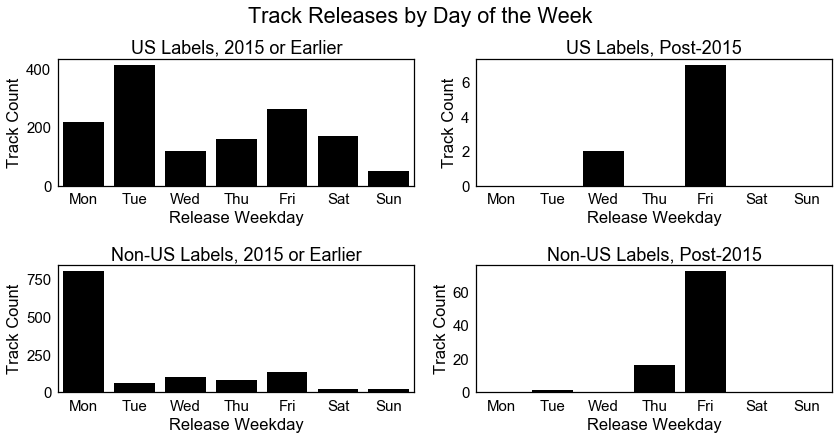

In [12]:
cols = ['release_year','release_month','release_day', 'label']
df_temp = df[cols].copy()

#Was the track released after 2015?
df_temp['post_2015'] = df_temp.release_year > 2015

#Split into mostly US and mostly not.
us_labels = ['Interscope', 'Warner Bros.', 'Universal/Island Def Jam', 
            'Capitol Records', 'Columbia', 'Rhino Atlantic']
non_us_labels = ['Warp Records', 'Planet Mu', 'Hymen Records', 
                 'Nettwerk Records', 'K-Tel']

#Drop tracks with label not in above list, then make a new column to
#distinguish between US and non-US labels.
df_temp = df_temp[ df_temp.label.isin(us_labels+non_us_labels) ]
df_temp['us_label'] = df_temp.label.isin(us_labels)

#Strings for plot labels.
mapping = {0:'Mon',1:'Tue',2:'Wed',3:'Thu',4:'Fri',5:'Sat',6:'Sun'}
s = df[cols].dropna().apply(date_to_weekday, axis=1)
s = s.map(mapping)
df_temp['release_weekday'] = s

order = ['Mon','Tue','Wed','Thu',
         'Fri','Sat','Sun']
g = sns.FacetGrid(df_temp, row='us_label', col='post_2015', size=3, 
                  row_order = [True,False], sharey=False, sharex=False, 
                  aspect=2, despine=False)
g.map(sns.countplot, 'release_weekday', order=order, color='black')

#Set subplot titles.
axes = g.axes.flatten()
axes[0].set_title('US Labels, 2015 or Earlier')
axes[1].set_title('US Labels, Post-2015')
axes[2].set_title('Non-US Labels, 2015 or Earlier')
axes[3].set_title('Non-US Labels, Post-2015')

#Set subplot axis labels
for axis in axes:
    axis.set_xlabel('Release Weekday')
    axis.set_ylabel('Track Count')

g.fig.suptitle('Track Releases by Day of the Week', y=1.03)

g.fig.tight_layout()

Nice! We can see the individual peaks much more clearly now. The US and non-US labels have peaks on Tuesday and Monday (respectively) prior to 2015, and both on Friday after 2015.

Actually, if we pay closer attention to the above article ([Why Are Albums Released on Tuesday (For Now) in the U.S.?](https://www.billboard.com/articles/news/6487452/album-release-day-why-tuesday)) even the convention of Tuesday US release dates only began in 1989, with Monday release dates prior to that. I leave it to the reader to verify that this pattern is *not* evident in our dataset. This may be partially due to problems with early `'release_year'`s that we will see in the next section.

## Release Year

Now, let's look at the year that each track was released. Early on, I had the suspicion that many older tracks would actually be re-releases. If so, this would skew the distribution of release dates towards later years. 

We'll investigate this by plotting the distribution of Billboard hits' release dates, for each Billboard Hot 100 decade.

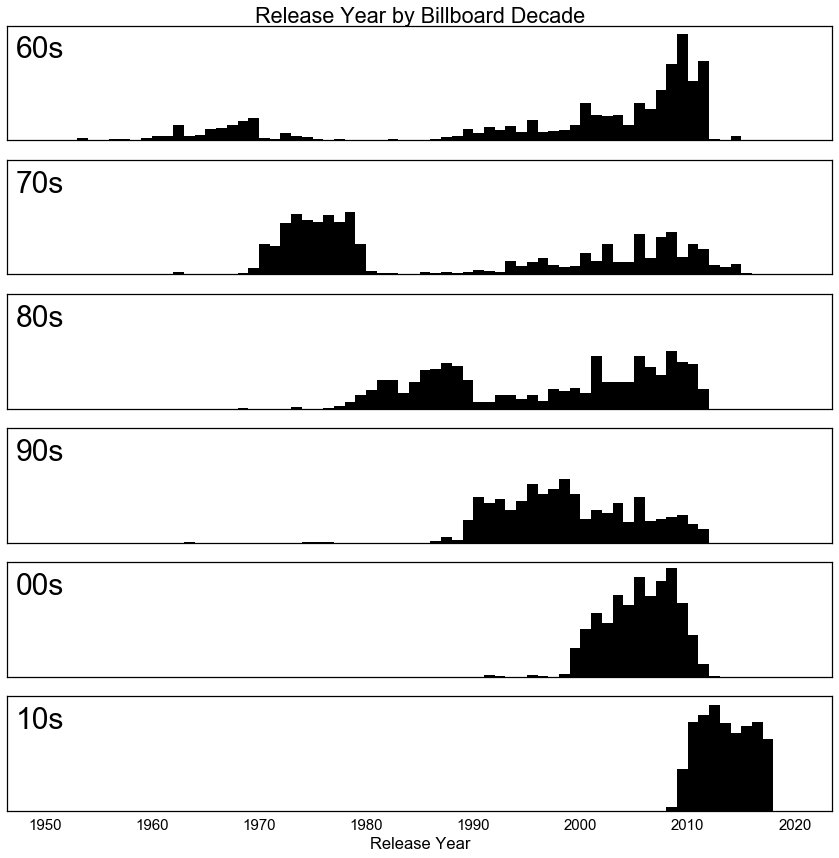

In [13]:
g = sns.FacetGrid(df, row='decade', size=2, aspect=6, despine=False)
g.map(plt.hist, 'release_year', bins=70, range=(1950,2020), color='black')

g.set(yticks=[])

#Custom subplot titles
titles = ['60s', '70s', '80s', '90s', '00s', '10s']
axes = g.axes.flatten()
for i,axis in enumerate(axes):
    axis.set_title(titles[i], x=.04, y=.67, fontsize=30 )
axes[-1].set_xlabel('Release Year')

g.fig.suptitle('Release Year by Billboard Decade', y=1)

g.fig.tight_layout()

This clearly confirms my suspicions. The release date distribution for each decade has two primary modes, one that falls within the appropriate decade (original release), and another that spans more recent decades (re-release).

It is also not particularly surprising to see a few tracks that were released just prior to the decade in which Billboard ranked them, as it can take time for a track to reach a high rank. It *is* surprising to see the presence of tracks with release dates up to three decades prior to their ranking decade. 

Let's have a look at these outliers:

In [14]:
#Tracks with a release year that precedes decade
cols = ['name','name_artist','decade','release_year']
df_temp = df[df.release_year<df.decade][cols]

#Sort by the amount of delay between release and ranking
df_temp['delay']=df_temp.decade - df_temp.release_year
df_temp.sort_values(by='delay', ascending=False).head(10)

,name,name_artist,decade,release_year,delay
8663,A Rose Is Still a Rose,Aretha Franklin,1990.0,1963,27.0
8605,I Don't Want to Miss a Thing,Aerosmith,1990.0,1974,16.0
8338,"December, 1963 [Oh What A Night!] (45 Version)",Frankie Valli & The Four Seasons,1990.0,1975,15.0
8075,Baby Got Back,Sir Mix-A-Lot,1990.0,1976,14.0
9064,Sexual Healing,Marvin Gaye,1980.0,1968,12.0
7183,One More Day,Diamond Rio,2000.0,1991,9.0
7438,I'm Still In Love With You,Sean Paul,2000.0,1991,9.0
10045,Monster Mash,"Bobby ""Boris"" Pickett",1970.0,1962,8.0
9903,Sealed with a Kiss,Bobby Vinton,1970.0,1962,8.0
7144,He Wasn't Man Enough,Toni Braxton,2000.0,1992,8.0


Before thinking too hard about these results, we can quickly confirm that some of these are simply mislabeled by Spotify. For example, **"Baby Got Back" by Sir Mix-A-Lot was not, in fact, released in 1976**. 

The Aretha Franklin and The Four Seasons tracks both had hit *remixes* in the 90s, and "Monster Mash" had a hit re-release in the 70s. The remaining tracks have been mislabeled by Spotify.

Since `'release_year'` is not a particularly accurate indicator of a track's original release year, we'll opt to instead use our `'decade'` variable when analyzing the Billboard dataset.

# Genres

Now let's dive into the genres associated with an artist (and thus associated with a track).

We'll need to group our dataframe by genre, but each track has multiple genres associated with it. This is stored in our `'genres'` column as one list of genres per row. Since Pandas seems to have no built-in syntax for grouping by such list elements, let's make our own grouping function:

## groupby_lists

In [8]:
# %%writefile groupby_lists.py
# #Not Pythonic. This is only so pandas import is included in groupby_lists.py
# #Otherwise, pandas is not in the module's namespace.
# import pandas as pd

def groupby_lists(df, col, col_name):
    """
    Groupby function for a column of lists.
    
    Parameters
    ----------
    df : Pandas DataFrame
    col : str
        The column of lists to group by.
    col_name : str
        A name for the resulting grouped column. e.g. if the original column 
        of lists was named 'models', a natural value for col_name would be 
        'model'.

    Returns
    -------
    Pandas GroupBy object

    """

    cols = df.columns
    
    #Expand lists to columns and join with original dataframe.
    df_exp = df[col].apply(pd.Series)
    df_exp = df_exp.join(df)
    
    #"Unpivot" expanded list columns.
    df_exp = df_exp.melt(id_vars=cols,value_name=col_name)
    
    #Drop the original column of lists, as well as superfluous 'variable' 
    #column from melt (which simply indicates the original position of the 
    #element in its corresponding list)
    df_exp = df_exp.drop([col,'variable'],axis=1)
    
    #Group by column of individual list elements.
    grouped = df_exp.groupby(col_name)
    
    return grouped

In short, `groupby_lists` does the following:

1. Expand each list to a collection of dataframe columns, with each column containing one of the list elements (padded with NaNs to give the same number of columns per row). The resulting column labels have no meaning aside from indicating the position of each list element in its original list. (e.g. element 0, element 1, etc.)

2. "Unpivot" the expanded list columns (ignoring NaNs). Effectively duplicates every row N times, where N is the number of elements in the row's list. The `id_vars` argument to `melt` identifies every column *except* for the expanded list columns. `col_name` is the label for the resulting column of individual list elements.

3. Drop unneeded columns and group by our new column of list elements.

We can test it on a simple toy example before applying it to our dataframe. Let's construct a dataframe of animals and the foods that they like to eat:


In [16]:
animals = ['human','cat','possum']
foods = [ ['avocado', 'oatmeal', 'sushi'],
        ['cat food', 'sushi'],
        ['avocado', 'oatmeal', 'sushi', 'cat food', 'ticks']]
df_temp = pd.DataFrame( {'animals':animals, 'foods':foods} )
df_temp

,animals,foods
0,human,"[avocado, oatmeal, sushi]"
1,cat,"[cat food, sushi]"
2,possum,"[avocado, oatmeal, sushi, cat food, ticks]"


Looks good. Let's apply our `groupby_lists` function to the `'foods'` column and see which animals like oatmeal.

In [17]:
by_food = groupby_lists(df_temp, 'foods', 'food')
by_food.get_group('oatmeal').animals

3     human
5    possum
Name: animals, dtype: object

We can also use our `by_food` object to get a list of animals per food:

In [18]:
by_food.animals.apply(list)

food
avocado          [human, possum]
cat food           [cat, possum]
oatmeal          [human, possum]
sushi       [cat, human, possum]
ticks                   [possum]
Name: animals, dtype: object

## Grouping by Genre

Let's use our new `groupby_lists` function to group our dataframe by genre. We'll use the resulting `by_genre` object heavily below and in later notebooks.

In [9]:
by_genre = groupby_lists(df,'genres','genre')

As our first application of our new `by_genre` object, we can visualize the top genres in each dataset. We'll generate a pair of simple Seaborn bar plots:

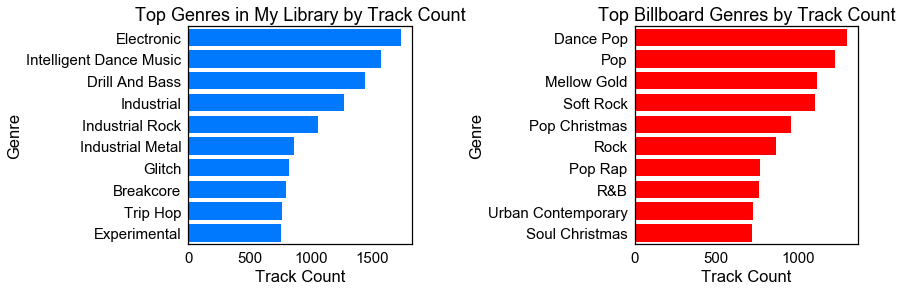

In [10]:
#Store genre counts for each dataset
df_temp = by_genre.ds.value_counts().to_frame(name='count').reset_index(
    ).sort_values(by='count', ascending=False)

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,4))

#Top 10 genres in 'nix' dataset.
df_temp2 = df_temp[df_temp.ds=='nix'].head(10)

p = sns.barplot(x='count',y='genre',data=df_temp2, color=blue, ax=ax1,
               saturation=1)
ax1.set_ylabel('Genre') 
ax1.set_xlabel('Track Count')
ax1.set_title('Top Genres in My Library by Track Count');

#Top 10 genres in 'top' dataset.
df_temp2 = df_temp[df_temp.ds=='top'].head(10)

p = sns.barplot(x='count',y='genre',data=df_temp2, color=red, ax=ax2,
               saturation=1)
ax2.set_ylabel('Genre') 
ax2.set_xlabel('Track Count')
ax2.set_title('Top Billboard Genres by Track Count');

plt.subplots_adjust(wspace=1.0)

We can see that there is no overlap in the top 10 genres of each dataset. The Billboard dataset is dominated by various types of pop and rock, while my dataset seems to be dominated by experimental electronic and industrial music. 

Note that some of these genres ("supergenres"?) subsume other genres, e.g. "Drill and Bass" and "Intelligent Dance Music" both fall under "Electronic" music, as well as "Experimental" music. The same goes for genres such as "Pop" or "Rock."

## Genre Purity

Since there is so little overlap in genres between datasets, genre might be a good predictor of which dataset a track comes from. Let's see how well genre indicates dataset by examining the genres' "purity." We define purity as the degree to which a genre is purely in one dataset or the other. So a purity of 0 indicates that a genre is equally present in both datasets, and a purity of 1 indicates that the genre is only present in one of the two datasets.

Let's plot the distribution of genre purity:

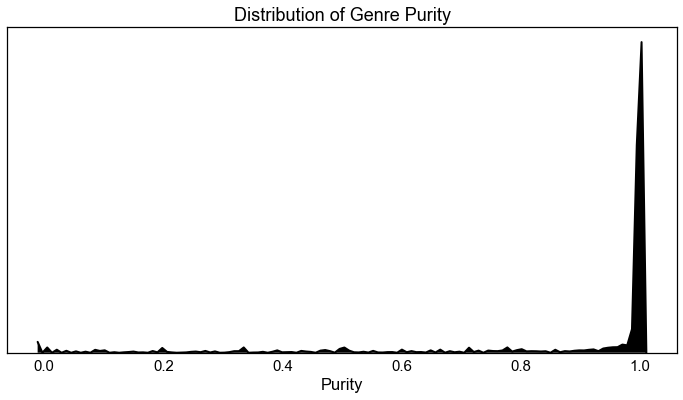

In [21]:
#Fraction of group's tracks in nix dataset
def nix_ratio(group):
    nix_count = (group=='nix').sum()
    top_count = (group=='top').sum()
    nix_ratio = nix_count/(nix_count+top_count) #Could use additive smoothing
    return nix_ratio

df_temp = by_genre.ds.agg(nix_ratio).to_frame().reset_index()

#Define "purity" to be 0 when equal odds to be in nix or top dataset
#1 when genre only found in one dataset.
df_temp['purity'] = 2*( df_temp['ds']-.5 ).abs()
df_temp.rename({'ds':'nix_ratio'}, axis='columns', inplace=True)

plt.figure( figsize=(12,6) )
p = sns.kdeplot(df_temp.purity, shade=True, legend=False,color='k', alpha=1,
                fillstyle='full' )

p.set_yticklabels([])
p.set_title('Distribution of Genre Purity')
p.set_xlabel('Purity');

This confirms that nearly all of the genres are almost perfectly "pure," which means genre is an excellent predictor of what dataset a track came from. 

It is perhaps an *unfairly* strong predictor. It is unclear how well such a predictor will generalize to tracks outside of these training datasets, or how to handle genres that are not present in our datasets. For example, the name of the album a track is from (`'name_album'`) would also be an excellent predictor when applied to our dataset, but would generalize to new tracks **very** poorly. This kind of overfitting cannot always be avoided by simple cross-validation, so we need to be smart about our feature selection when we start to build our predictive model.

## Artists by Genre

In our toy animal/food example, we converted a dataframe of **lists of foods** *per animal* into a dataframe of **lists of animals** *per food*. Now, let's use our `groupby_lists` function to build a dataframe of **lists of artists** *per genre*. 

We'll focus on my library since the Billboard dataset has too many artists per genre to display.

In [22]:
#Group by genre on 'nix' dataset by itself
by_genre_nix = groupby_lists( df[df.ds=='nix'], 'genres', 'genre')

#Create column of artist lists, and sort each list by name
df_temp = by_genre_nix.name_artist.unique().to_frame().reset_index()
df_temp['name_artist'] = df_temp['name_artist'].transform( sorted )

#Create number of artists column from these lists
df_temp['num_artists'] = df_temp['name_artist'].transform( lambda x: len(x) )

#Using .style with no parameters to display full artist lists.
df_temp.sort_values('num_artists', ascending=False).head(10).style

,genre,name_artist,num_artists
91,Drill And Bass,"['AFX', 'Acrnym', 'Amon Tobin', 'Autechre', 'B12', 'Ceephax Acid Crew', 'Clark', 'Cylob', 'DJ Scotch Egg', ""Datach'i"", 'Datassette', 'Dev/Null', 'Doormouse', 'Drumcorps', 'Duran Duran Duran', 'Emotional Joystick', 'End.user', 'Gescom', 'Global Goon', 'Hrvatski', 'Igorrr', 'Jega', 'Kid Spatula', 'Kid606', 'Mike & Rich', ""Nero's Day At Disneyland"", 'Otto Von Schirach', 'Plaid', 'Richard Devine', 'Seefeel', 'Shobaleader One', 'Squarepusher', 'The Flashbulb', 'The Future Sound Of London', 'Tim Exile', 'Tom Jenkinson', 'Venetian Snares', 'Venetian Snares + Speedranch', 'Xanopticon', 'µ-Ziq']",40
104,Electronic,"['AFX', 'Amon Tobin', 'Aphex Twin', 'Autechre', 'B12', 'Björk', 'Blanck Mass', 'Boards of Canada', 'Burial', 'Clark', 'Coldcut', 'Fluke', 'Gary Numan', 'Jean-Michel Jarre', 'John Maus', 'Jon Hopkins', 'Justice', 'KMFDM', 'Kraftwerk', 'Massive Attack', 'Nine Inch Nails', 'Oneohtrix Point Never', 'Orbital', 'Pendulum', 'Plaid', 'Portishead', 'Sneaker Pimps', 'Squarepusher', ""Stereo MC's"", 'The Chemical Brothers', 'The Future Sound Of London', 'The Knife', 'The Prodigy', 'Underworld', 'Venetian Snares', 'µ-Ziq']",36
164,Intelligent Dance Music,"['AFX', 'Amon Tobin', 'Aphex Twin', 'Autechre', 'B12', 'Blanck Mass', 'Boards of Canada', 'Ceephax Acid Crew', 'Clark', 'Cylob', ""Datach'i"", 'Datassette', 'Doormouse', 'Emotional Joystick', 'Fluke', 'Gescom', 'Global Goon', 'Hrvatski', 'Jega', 'Kangding Ray', 'Kid606', 'Nautilis', 'Oneohtrix Point Never', 'Orbital', 'Plaid', 'Richard Devine', 'Richard H. Kirk', 'Seefeel', 'Squarepusher', 'The Flashbulb', 'The Future Sound Of London', 'Venetian Snares', 'µ-Ziq']",33
161,Industrial,"[':Wumpscut:', 'Atari Teenage Riot', 'Autechre', 'Coil', 'Covenant', 'Esplendor Geométrico', 'Fad Gadget', 'Gary Numan', 'How To Destroy Angels', 'KMFDM', 'Leæther Strip', 'Lords Of Acid', 'MDFMK', 'Marilyn Manson', 'Merzbow', 'Ministry', 'Nine Inch Nails', 'Nitzer Ebb', 'OHGr', 'Prurient', 'Rammstein', 'Revolting Cocks', 'Richard H. Kirk', 'Scorn', 'Skinny Puppy', 'Sunn 0)))', 'The Residents', 'Throbbing Gristle', 'Tuxedomoon', 'VNV Nation', 'Whitehouse', 'Youth Code']",32
163,Industrial Rock,"[':Wumpscut:', 'Atari Teenage Riot', 'Coil', 'Covenant', 'Deadsy', 'Fad Gadget', 'Filter', 'Gary Numan', 'Grendel', 'How To Destroy Angels', 'KMFDM', 'Leæther Strip', 'Lords Of Acid', 'MDFMK', 'Marilyn Manson', 'Ministry', 'Nine Inch Nails', 'Nitzer Ebb', 'OHGr', 'Rammstein', 'Revolting Cocks', 'Rob Zombie', 'Skinny Puppy', 'Suicide Commando', 'The Residents', 'Throbbing Gristle', 'Trent Reznor', 'Tuxedomoon', 'VNV Nation', 'Youth Code']",30
162,Industrial Metal,"[':Wumpscut:', 'And One', 'Atari Teenage Riot', 'Covenant', 'Deadsy', 'Filter', 'Funker Vogt', 'Grendel', 'Hocico', 'How To Destroy Angels', 'KMFDM', 'Leæther Strip', 'Lords Of Acid', 'MDFMK', 'Marilyn Manson', 'Ministry', 'Nine Inch Nails', 'Nitzer Ebb', 'OHGr', 'Psyclon Nine', 'Rammstein', 'Revolting Cocks', 'Rob Zombie', 'Rotersand', 'Skinny Puppy', 'Suicide Commando', 'VNV Nation', 'Youth Code']",28
37,Breakcore,"['AFX', 'Acrnym', 'Bomb 20', 'Broken Note', 'Ceephax Acid Crew', 'DJ Scotch Egg', ""Datach'i"", 'Dev/Null', 'Doormouse', 'Drumcorps', 'Duran Duran Duran', 'Emotional Joystick', 'End.user', 'Hrvatski', 'Igorrr', 'Jega', 'John B & Exile', 'Kid606', 'Lauren Bousfield', ""Nero's Day At Disneyland"", 'Otto Von Schirach', 'Richard Devine', 'The Flashbulb', 'Venetian Snares', 'Venetian Snares + Speedranch', 'Xanopticon', 'µ-Ziq']",27
79,Deep Chiptune,"['Ben Prunty', 'Big Giant Circles', 'Bignic', 'C418', 'Carpenter Brut', 'Covox', 'Danny Baranowsky', 'Disasterpeace', 'Eirik Suhrke', 'Hyperduck Soundworks', 'Jim Guthrie', 'Lauren Bousfield', 'Mick Gordon', 'Mikko Tarmia', 'Perturbator', 'Scattle', 'Solar Fields', 'The Algorithm', 'The Flashbulb', 'cTrix', 'scntfc', 'zabutom']",22
310,Trip Hop,"['Amon Tobin', 'Aphex Twin', 'Autechre', 'Björk', 'Boards of Canada', 'Burial', 'Clark', 'Coldcut', 'Fluke',

We can see that there is indeed a large overlap between genres (and "supergenres"). For example, the list of artists categorized as "Intelligent Dance Music" is similar to the list of artists categorized as "Drill and Bass." 

Let's see their set intersection:

In [27]:
#Create sets of artists for first 2 genres and their intersection
artists_drill = set( df_temp[df_temp.genre=='Drill And Bass'].
                  name_artist.values[0] )
artists_idm = set( df_temp[df_temp.genre=='Intelligent Dance Music'].
                  name_artist.values[0] )
artists_both = artists_drill.intersection(artists_idm)

print("""Artists categorized as both "Drill and Bass" \
and "Intelligent Dance Music": \n""")
print(artists_both)
print( '\n({} artists total)'.format( len(artists_both)) )

Artists categorized as both "Drill and Bass" and "Intelligent Dance Music": 

{'Global Goon', "Datach'i", 'The Future Sound Of London', 'Seefeel', 'Clark', 'Gescom', 'Doormouse', 'The Flashbulb', 'Datassette', 'Venetian Snares', 'µ-Ziq', 'Jega', 'Amon Tobin', 'Emotional Joystick', 'Cylob', 'Richard Devine', 'Kid606', 'Ceephax Acid Crew', 'AFX', 'Autechre', 'Squarepusher', 'Plaid', 'Hrvatski', 'B12'}

(24 artists total)


So 24 of the 40 artists categorized as Drill and Bass are also categorized as Intelligent Dance Music (and vice versa).

*Exercise for the reader: Construct a numerical measure (e.g. entropy) of genre diversity and apply it to the two datasets. Compare it with a similar measure of artist diversity.*

## Genre Ranking Chart

As a final analysis of genre, let's visualize the most popular genres over the decades. We'll group the Billboard tracks by decade and count the occurrence of each genre. Note that we do *not* factor in the actual Billboard rank of each track, but rather treat the top $100\times10=1000$ tracks per decade as a representative sample of what tracks (and therefore genres) are popular.

### Ranking Dataframe

First, let's construct a dataframe to represent our per-decade genre ranking. The resulting dataframe will be indexed by rank, and have one column per decade. An explanation of each step can be found in the comments below:

In [28]:
#Music Rankings (per Decade) Dataframe

#Get decade counts per genre and turn into a dataframe. Rename wrapper column
#from default ("decade") to "count" since there is an existing "decade" column
#that would interfere with the following step: 
#Reset the index to remove said wrapper column.
df_genre_decade = by_genre.decade.value_counts().to_frame(name='count'
                                                         ).reset_index()

#Sort by decade, then track count for each genre.
df_genre_decade.sort_values(by=['decade','count'], ascending=[True,False], 
                            inplace=True)

#Re-index by decade, and drop "count" since it has served its purpose (sorting)
df_genre_decade.set_index('decade', inplace=True)
df_genre_decade.drop('count', axis=1, inplace=True)

#Build names for our ranking columns, and pull out integer decades from index
col_names = ['1960s','1970s','1980s','1990s','2000s','2010s']
decades = df_genre_decade.index.unique()

#Make list of ranked genres for each decade. Use cross-section (df.xs) instead
#of e.g. df.loc since index has repeated values. 
#Only pull top 100 genres.
rankings = [ df_genre_decade.xs(decade).genre.head(100).values 
        for decade in decades ]

#Create dict of column names and per-decade rankings, and build rank dataframe
data_dict = { col_name:ranking 
             for col_name,ranking in zip(col_names,rankings) }
df_rank = pd.DataFrame(data_dict)

#Set index to start from 1, like a ranking.
df_rank.index = np.arange(1, len(df_rank) + 1)

df_rank.head(10)

,1960s,1970s,1980s,1990s,2000s,2010s
1,Brill Building Pop,Soft Rock,Soft Rock,Dance Pop,Dance Pop,Pop
2,Adult Standards,Mellow Gold,Mellow Gold,Urban Contemporary,Pop,Dance Pop
3,Rock-And-Roll,Folk Rock,Rock,Pop Christmas,Pop Rap,Pop Rap
4,Christmas,Classic Rock,Album Rock,R&B,R&B,Post-Teen Pop
5,Folk Rock,Disco,New Wave Pop,Hip Pop,Pop Christmas,Pop Christmas
6,Bubblegum Pop,Classic Funk Rock,Dance Rock,New Jack Swing,Urban Contemporary,Rap
7,Merseybeat,Rock,Classic Rock,Hip Hop,Hip Pop,Hip Hop
8,Classic Rock,Album Rock,Disco,Soul Christmas,Hip Hop,R&B
9,Motown,Adult Standards,New Romantic,Pop,Rap,Trap Music
10,Soul,Motown,Quiet Storm,Neo Soul,Southern Hip Hop,Southern Hip Hop


This looks good, albeit a bit basic. Let's use this dataframe as a starting point, and build something nicer.

### Ranking Chart

We'll display our rankings as a set of stacked rectangles. To assist the viewer in tracking each genre over time, we'll draw lines connecting these rectangles (resembling Edward Tufte's ["slopegraphs"](http://charliepark.org/slopegraphs/) ). 

When a genre appears in the ranking for the first time that decade, we'll indicate this with a black bar on the left side of the rectangle. Similarly, when a genre appears for the *last* time that decade, we'll draw a black bar to the right of the rectangle.

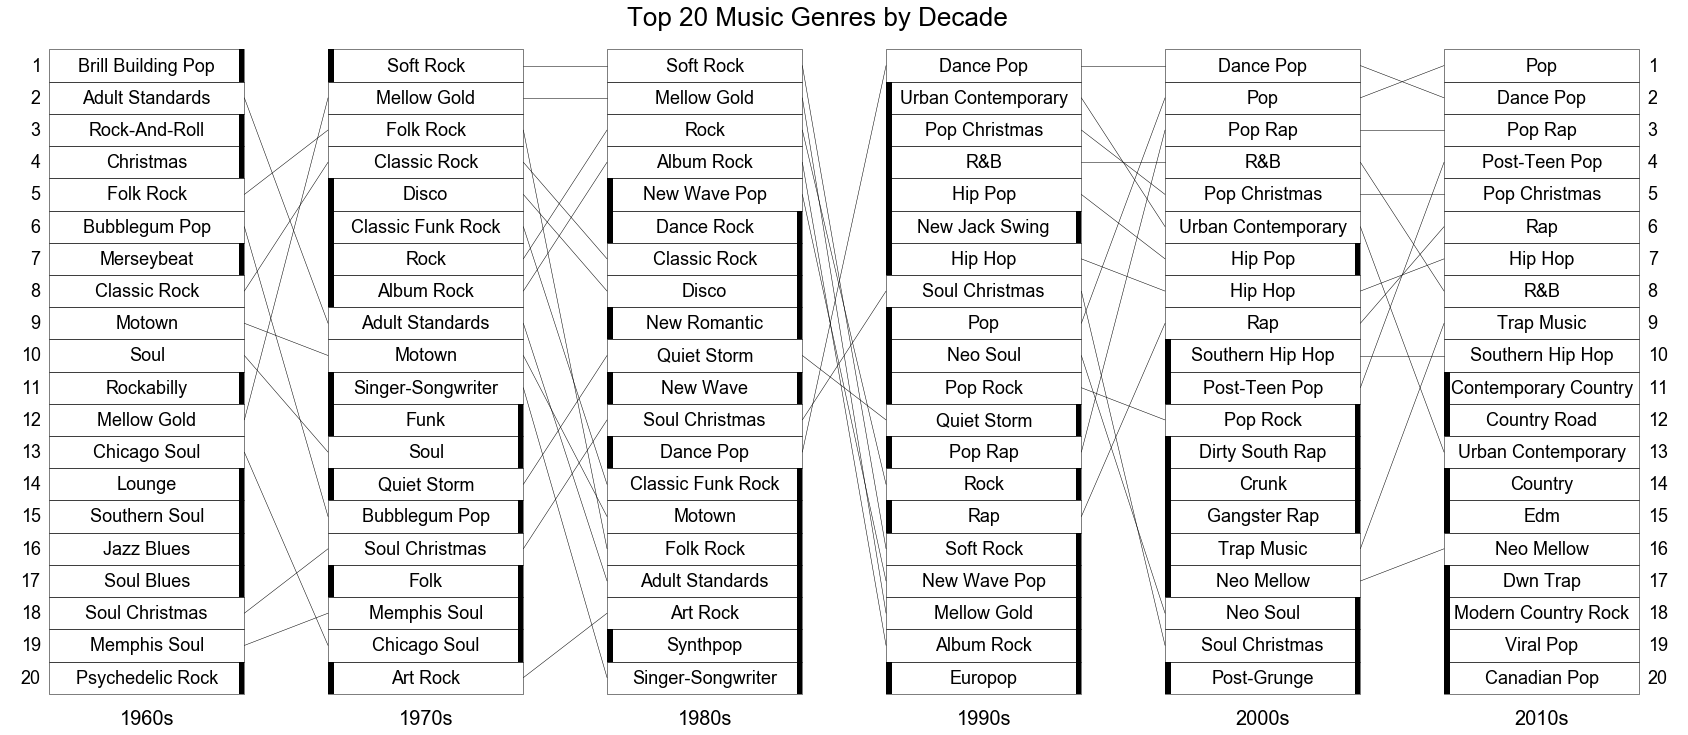

In [29]:
import matplotlib.patches as patches

#Set up figure
fig = plt.figure(figsize=(30,12))
ax = fig.add_subplot(111)
ax.axis([0.5, 6.5, 20.75, 0.5])

#Set title
fig.suptitle('Top 20 Music Genres by Decade', y=.93, fontsize=26)

#Dimensions of rectangles to be plotted, in axis co-ordinates
rect_width = 0.7
rect_height = 1.0

for i,decade in enumerate(df_rank.columns):
    for j,genre in enumerate( df_rank[decade].head(20) ):
        
        #Draw genre names
        ax.text(i+1, j+1, genre, horizontalalignment='center', 
                verticalalignment='center')
        
        #Draw rectangles around all genre names
        rect = patches.Rectangle((i+1-rect_width/2,j+1-rect_height/2),
                                 rect_width,rect_height, linewidth=0.5,
                                 edgecolor='k',facecolor='none')
        ax.add_patch(rect)
        
        #Booleans for conditionals below. Tests if we are in the first
        #(or last) column (respectively).
        not_first = (i!=0)
        not_last = (i!=5)
        
        #More booleans:
        #If the current genre is not present in the previous column, it is a
        #"new" genre:
        new_genre = (genre not in df_rank.iloc[:,i-1].head(20).values)
        #If the current genre is not present in the *next* column, it is a
        #"dying" genre:
        dying_genre = (genre not in df_rank.iloc[ :, (i+1)%6 ].head(20).values)
        
        #If the current genre is "new," and the current column is not the first
        #column, draw a black bar to the left of the genre name.
        if new_genre and not_first:
            rect = patches.Rectangle((i+1-rect_width/2,j+1-rect_height/2),
                                     .02,rect_height, facecolor='k')
            ax.add_patch(rect)

        #If the current genre is "dying," and the current column is not the 
        #*final* column, draw a black bar to the *right* of the genre name.
        if dying_genre and not_last:
            rect = patches.Rectangle((i+1+rect_width/2-.02,j+1-rect_height/2),
                                     .02,rect_height, facecolor='k')
            ax.add_patch(rect)
        
        #If a genre is present in two consecutive columns, draw a line
        #connecting the corresponding genre's name in the two columns.
        for j2,genre2 in enumerate( df_rank.iloc[:,i-1].head(20) ):
            if genre == genre2:
                ax.plot([i+rect_width/2, i+1-rect_width/2], 
                        [j2+1,j+1], color='k', lw=.5)

#Label the ranking to the left of first column and right of final column
for j in range(20):
    ax.text(1-rect_width/2-.03, j+1, repr(j+1), horizontalalignment='right', 
            verticalalignment='center')
    ax.text(6+rect_width/2+.03, j+1, repr(j+1), horizontalalignment='left', 
            verticalalignment='center')                

#Hide all axis spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

#Set decade labels
ax.set_xticklabels(['','1960s','1970s','1980s','1990s','2000s','2010s'])
ax.set_yticklabels([])
ax.tick_params(labelsize=20)

plt.show()

Nice! Now we can track the birth, rise, fall, and death of each genre over the decades.

- We can see the fall of manufactured **Brill Building Pop** in the 60s, as well as the [fall of **Rock-And-Roll**](https://www.npr.org/sections/therecord/2016/09/22/495021326/1966-vs-1971-when-rock-n-roll-became-rock-and-what-we-lost) in the 60s, and and rise of its replacements such as **Rock**, **Soft Rock**, and **Classic Rock** in the 70s.

- The fall of **Adult Standards** in the 60s-70s, can be attributed to the fact that the genre is essentially defined by an age demographic, and therefore a time period (pre ~1970s and mostly 1940s-1950s)

- We see the rise of **Disco** in the 70s, its fall in the 80s, and a similar rise and fall of **New Wave** and related genres in the 80s.

- The biggest changes come in the 90s where we see a huge influx of **Hip Hop** and **R&B** (and related), supplanting most of the top genres of the 80s. This is to be topped only by the sudden rise of 90s **Dance Pop**.

- The popularity of **Hip Hop** and **R&B** continues through the 2000s, while **Pop** and **Rap** rise to share the top with **Dance Pop** &mdash; a trend that is maintained through the 2010s.

- Some genres are particularly short-lived in the rankings. Aside from the previously mentioned **Disco** and **New Wave**, trends of the 70s and 80s (respectively), there is the rise and fall of **Funk** in the 70s, and the rise and fall of **New Jack Swing** ([RIP](https://www.youtube.com/watch?v=YejxyaFyUHc)) in the 90s. **Crunk** and **Dirty South Rap** rose and fell in popularity in the 2000s, as did **Gangsta Rap** (in name alone).

- "**Christmas**" music also fell in popularity 60s, which is due to the fact that most Christmas music (to this day) originated in the 60s or earlier. We also see an influx of new Christmas hits starting in the 90s, primarily under the **Pop Christmas** genre.

# End
Now that we have an understanding of these basic variables, let's dive into exploring the tracks' **audio** itself: 

[Part 3: Audio Features](spotify_3_audio_features.ipynb)

---

< [Part 1: Scraping and Wrangling](spotify_1_scraping.ipynb) | [Main](index.ipynb) | [Part 3: Audio Features](spotify_3_audio_features.ipynb) >